In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import smact
import umap
from matplotlib.ticker import FixedLocator, FormatStrFormatter
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from AtomicEmbeddings.core import Embedding

sns.set(font_scale=2)

# Set up the Atomic Embedding features

# Create a list of the CBFVs we are interested in
cbfvs = ["mat2vec", "random_200", "magpie_sc", "megnet16"]

# Create a dictionary of {cbfv: AtomicEmbeddings}
AtomEmbeds = {cbfv: Embedding.load_data(cbfv) for cbfv in cbfvs}

# Only keep the first 83 elements for the Atomic Embeddings

# For now Smact is used, but a future update will aim to remove this dependency
el_symbols = smact.ordered_elements(1, 83)

# Iterate over the AtomEmbeds to remove the elements

for cbfv in cbfvs:
    # Get the keys of the atomic embeddings object
    elements = set(AtomEmbeds[cbfv].element_list)
    el_symbols_set = set(el_symbols)

    # Get the element symbols we want to remove
    els_to_remove = list(elements - el_symbols_set)

    # Iteratively delete the elements with atomic number
    # greater than 83 from our embeddings
    for el in els_to_remove:
        del AtomEmbeds[cbfv].embeddings[el]

    # Verify that we have 83 elements
    print(len(AtomEmbeds[cbfv].element_list))

/Users/aonwu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


83
81
83
83


In [2]:
AtomicEmbed = AtomEmbeds["mat2vec"]
# Create an array of the embedding vectors
embeddings_array = np.array(list(AtomicEmbed.embeddings.values()))
# Create an array of the elements
element_array = np.array(AtomicEmbed.element_list)

# Perform the PCA
pca = decomposition.PCA()  # project to 2 dimensions
pca.fit(embeddings_array)
X = pca.transform(embeddings_array)
print(embeddings_array.shape)
print(X.shape)
a = pca.explained_variance_ratio_ * 100
a.sum()

(83, 199)
(83, 83)


99.99999999999999

In [3]:
len(embeddings_array)

83

In [4]:
AtomicEmbed = AtomEmbeds["magpie_sc"]
# Create an array of the embedding vectors
embeddings_array = np.array(list(AtomicEmbed.embeddings.values()))
# Create an array of the elements
element_array = np.array(AtomicEmbed.element_list)

# Perform the PCA
pca = decomposition.PCA()  # project to 2 dimensions
pca.fit(embeddings_array)
X = pca.transform(embeddings_array)
print(X.shape)
a = pca.explained_variance_ratio_ * 100
a.sum()

(83, 22)


100.00000000000003

In [5]:
x = np.linspace(1, 22, 22) * 100 / 22
x.shape

(22,)

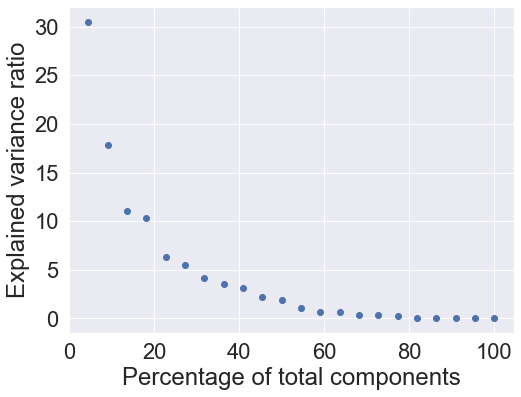

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(
    x,
    a,
)
ax.set_xlabel("Percentage of total components")
ax.set_ylabel("Explained variance ratio")

# plt.tight_layout()
plt.show()

In [7]:
X[0]

array([ 2.84538263e+00, -4.12320438e+00,  2.15225848e+00, -2.98415884e-01,
        1.76978610e+00, -6.46749199e-01, -1.18244603e-01,  1.07184718e+00,
        1.42865706e+00, -2.76483324e-01, -1.56464263e+00,  1.29863166e-01,
        6.27939349e-01, -7.18653837e-01, -2.49674901e-01,  1.04141570e+00,
        8.05670698e-01,  1.51168826e-01, -7.87520583e-02, -8.32090772e-03,
       -3.34483236e-16,  6.70933678e-16])

In [8]:
X.shape

(83, 22)

In [9]:
pca.explained_variance_

array([6.43390761e+00, 3.75825127e+00, 2.32252549e+00, 2.18864707e+00,
       1.33825391e+00, 1.17036669e+00, 8.85025155e-01, 7.39845366e-01,
       6.63339832e-01, 4.73631873e-01, 3.91442164e-01, 2.24331483e-01,
       1.45161678e-01, 1.37071045e-01, 8.06888899e-02, 7.63168066e-02,
       5.20451216e-02, 1.87585224e-02, 2.62311089e-03, 8.93199344e-05,
       1.12710583e-31, 2.62919455e-32])

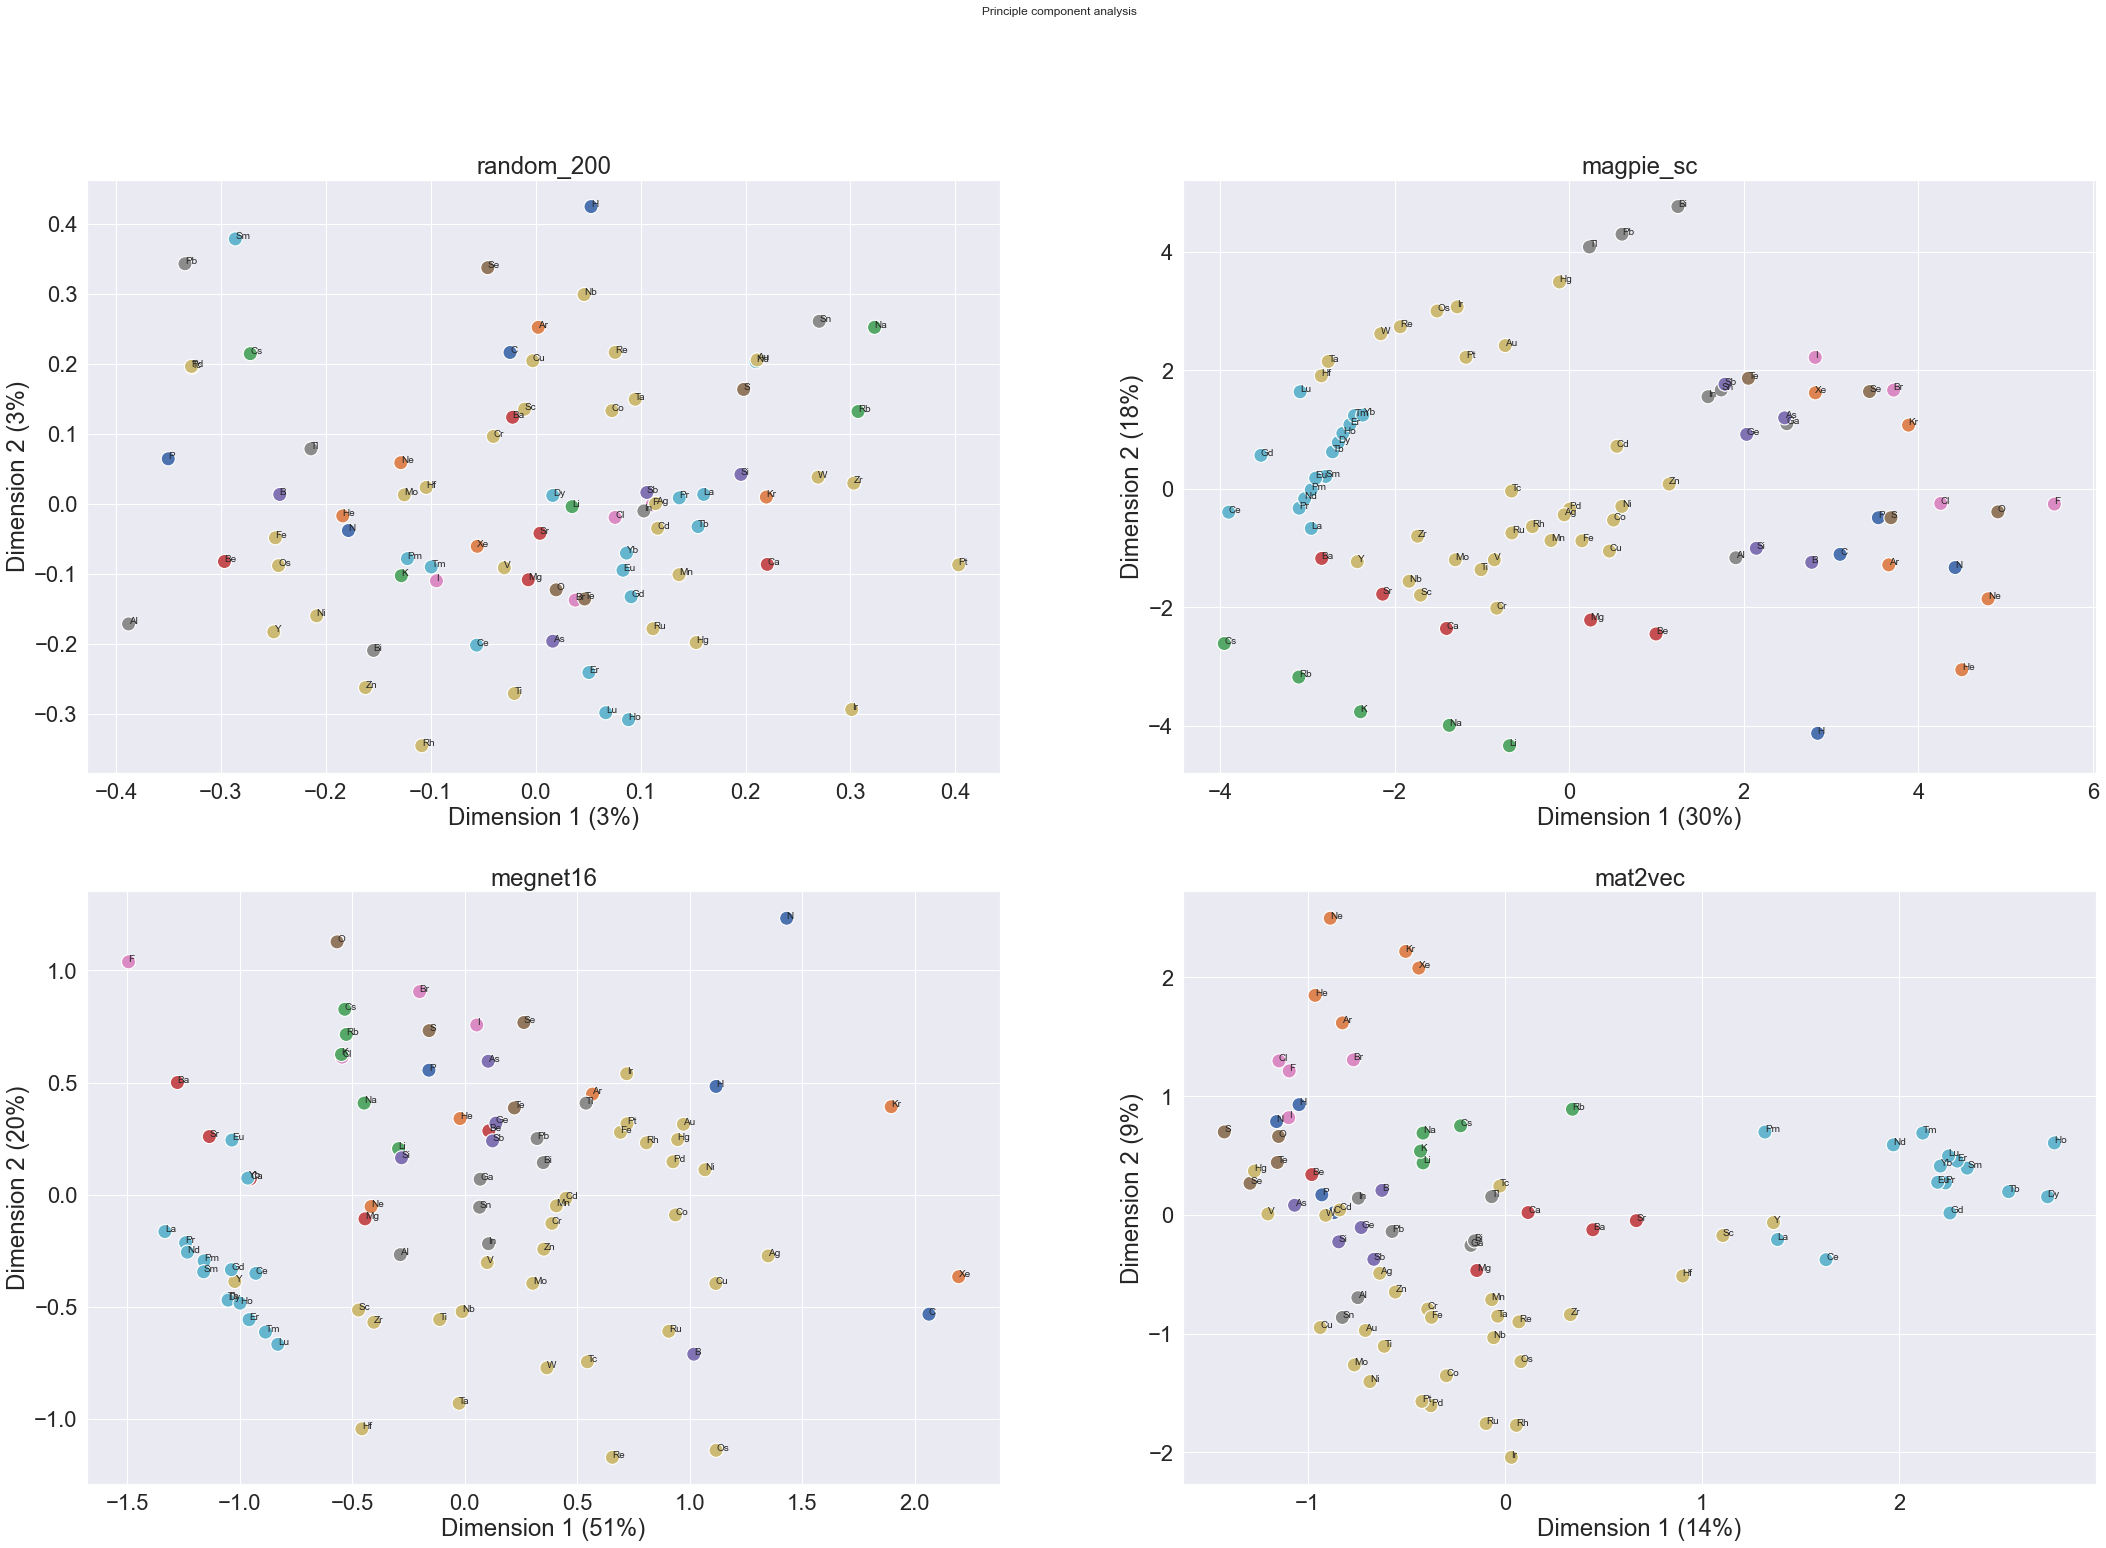

In [10]:
# Make the PCA plots
var_list = []
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(36, 24))
axes = [ax1, ax2, ax3, ax4]
fig.suptitle("Principle component analysis")
for i, cbfv in enumerate(cbfvs):
    AtomicEmbed = AtomEmbeds[cbfv]

    # Create an array of the embedding vectors
    embeddings_array = np.array(list(AtomicEmbed.embeddings.values()))
    # Create an array of the elements
    element_array = np.array(AtomicEmbed.element_list)

    # Perform the PCA
    pca = decomposition.PCA()  # project to 2 dimensions
    pca.fit(embeddings_array)
    X = pca.transform(embeddings_array)
    exp_var = pca.explained_variance_ratio_

    pca_dim1 = X[:, 0]
    pca_dim2 = X[:, 1]
    # Create a dataframe to store the dimensions,
    # labels and group info for the PCA
    pca_df = pd.DataFrame(
        {
            "pca_dim1": pca_dim1,
            "pca_dim2": pca_dim2,
            "element": element_array,
            "group": list(AtomicEmbed.element_groups_dict.values()),
        }
    )
    var_dict = {
        "atom_embed": cbfv,
        "exp_var": exp_var * 100,
        "percent_component": np.linspace(1, X.shape[1], X.shape[1]) * 100 / X.shape[1],
        "exp_var_cumsum": np.cumsum(exp_var * 100),
    }
    var_list.append(var_dict)

    g = sns.scatterplot(
        x="pca_dim1",
        y="pca_dim2",
        data=pca_df,
        hue="group",
        s=200,
        ax=axes[i - 1],
        legend=False,
    )

    axes[i - 1].set_xlabel(f"Dimension 1 ({exp_var[0]*100:.0f}%)")
    axes[i - 1].set_ylabel(f"Dimension 2 ({exp_var[1]*100:.0f}%)")

    for idx in range(len(X)):
        axes[i - 1].text(
            x=pca_dim1[idx],
            y=pca_dim2[idx],
            s=element_array[idx],
        )

    # Title the plots
    axes[i - 1].title.set_text(cbfv)


plt.show()

In [11]:
var_df = pd.DataFrame(var_list)
var_df

,atom_embed,exp_var,percent_component,exp_var_cumsum
0,mat2vec,"[13.996326275053642, 8.734133330876883, 7.6580...","[1.2048192771084338, 2.4096385542168677, 3.614...","[13.996326275053642, 22.730459605930527, 30.38..."
1,random_200,"[3.2771919842016946, 2.9997025925278464, 2.915...","[1.2345679012345678, 2.4691358024691357, 3.703...","[3.2771919842016946, 6.276894576729541, 9.1923..."
2,magpie_sc,"[30.489097304543893, 17.80965714043729, 11.006...","[4.545454545454546, 9.090909090909092, 13.6363...","[30.489097304543893, 48.298754444981185, 59.30..."
3,megnet16,"[51.11944100880058, 20.137881875728763, 10.382...","[6.25, 12.5, 18.75, 25.0, 31.25, 37.5, 43.75, ...","[51.11944100880058, 71.25732288452934, 81.6402..."


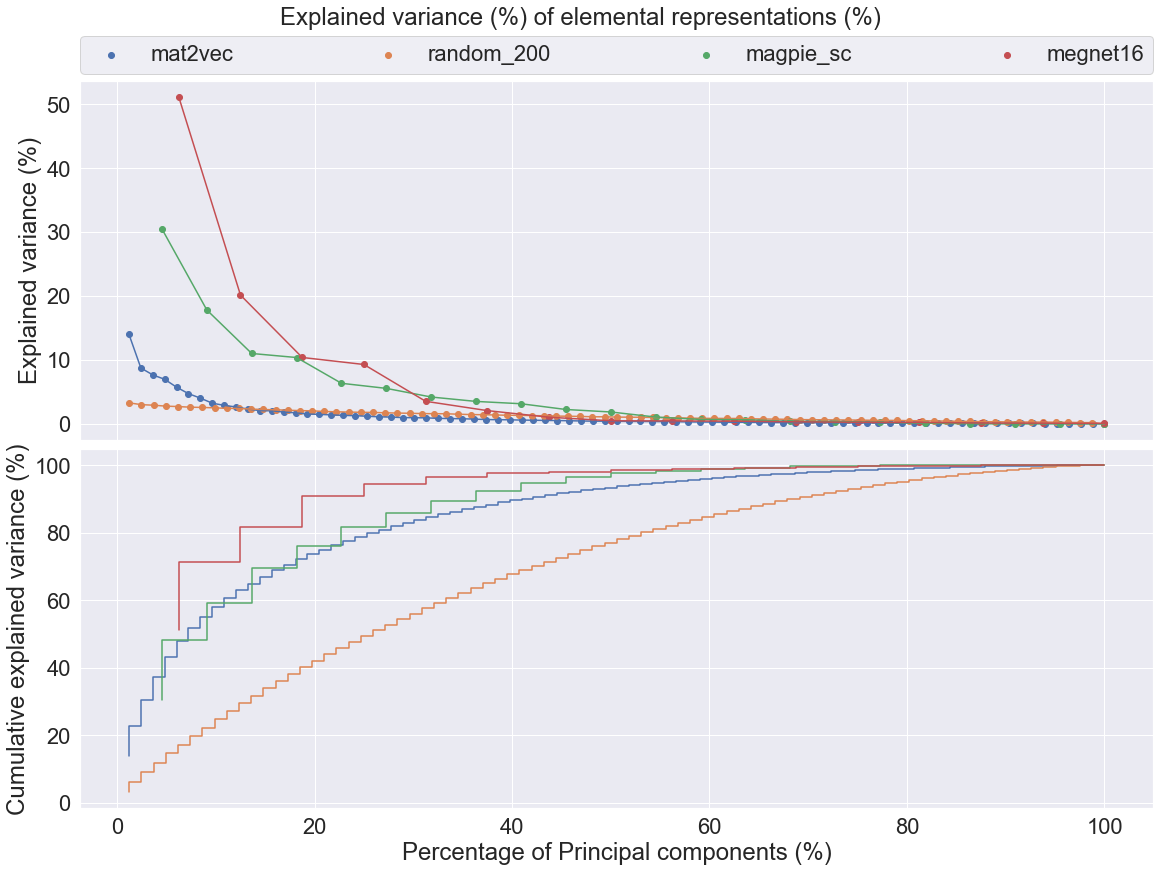

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12), constrained_layout=True, sharex=True)
handles = []
for i, row in var_df.iterrows():
    g = ax[0].scatter(
        y=row["exp_var"], x=row["percent_component"], label=row["atom_embed"]
    )

    ax[0].plot(
        row["percent_component"],
        row["exp_var"],
    )
    ax[0].legend(
        loc="lower left",
        bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
        mode="expand",
        ncols=4,
        borderaxespad=0.0,
    )
    handles.append(g)

    ax[1].step(x=row["percent_component"], y=row["exp_var_cumsum"])

# ax[0].set

ax[1].set_xlabel("Percentage of Principal components (%)")
ax[1].set_ylabel("Cumulative explained variance (%)")
ax[0].set_ylabel("Explained variance (%)")
# ax[].legend(loc='best')
# fig.legend(handles,var_df['atom_embed'], loc = 'right')
# plt.subplots_adjust(right=0.7)
# fig.text(0.04,0.5, 'Explained variance score (%)', va='center',rotation='vertical')#
# plt.ylabel("Exp")
# fig.supylabel("Explained variance score (%)",fontsize=20)
fig.suptitle("Explained variance (%) of elemental representations (%)", fontsize=24)

# plt.savefig("Variance.jpg", transparent=False)
plt.show()

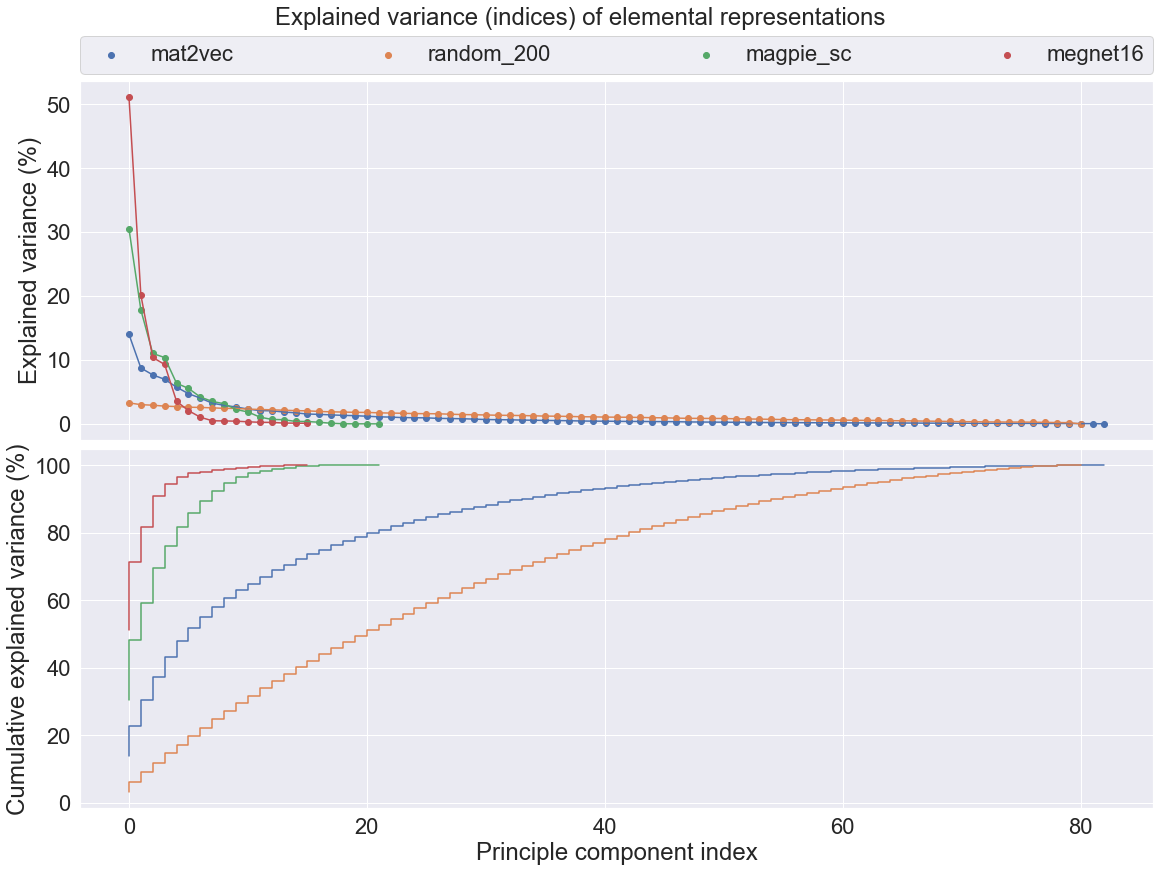

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12), constrained_layout=True, sharex=True)
handles = []
for i, row in var_df.iterrows():
    g = ax[0].scatter(
        y=row["exp_var"], x=range(0, len(row["exp_var"])), label=row["atom_embed"]
    )

    ax[0].plot(
        range(0, len(row["exp_var"])),
        row["exp_var"],
    )
    ax[0].legend(
        loc="lower left",
        bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
        mode="expand",
        ncols=4,
        borderaxespad=0.0,
    )
    handles.append(g)

    ax[1].step(x=range(0, len(row["exp_var"])), y=row["exp_var_cumsum"])

# ax[0].set

ax[1].set_xlabel("Principle component index")
ax[1].set_ylabel("Cumulative explained variance (%)")
ax[0].set_ylabel("Explained variance (%)")
fig.suptitle("Explained variance (indices) of elemental representations", fontsize=24)
# ax[].legend(loc='best')
# fig.legend(handles,var_df['atom_embed'], loc = 'right')
# plt.subplots_adjust(right=0.7)
# fig.text(0.04,0.5, 'Explained variance score (%)', va='center',rotation='vertical')#
# plt.ylabel("Exp")
# fig.supylabel("Explained variance score (%)",fontsize=20)
# plt.savefig("Variance_index.jpg", transparent=False)
plt.show()